# Model error analysis notebook
For error analysis workflow of PV vs non-PV trained models. Uses the v1.0 or v2.0 master datasets to retrieve actual TOTALDEMAND values, together with supporting data such as TEMPERATURE, POWER, etc.

Expects two input experiment files of predictions (one with PV, one without PV) over an equivalent forecast date range.
Experiments files are a 2-column .CSV of format:
DATETIME                TOTALDEMAND
YYYY-MM-DD HH:MM:SS     Float

These names of these input files are specified in the PV_FILE and NO_PV_FILE variables (see below). The main datafile that is used for comparison is specified in ACTUALS_FILE

At this point, the notebook processes data on a state-by-state basis. The state being analysed must be specified in the STATE variable.

In [1]:
from darts import TimeSeries
from darts.metrics import mape, rmse  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from darts.utils.statistics import plot_hist, plot_residuals_analysis, plot_acf, plot_pacf
from darts.models import NaiveSeasonal

# Enable multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# Directory where the combined master project datafile is
DATA_PATH = "../../data/UNSW-PROJECT-DATA/"

#Filename of the combined master project file with the actual values
ACTUALS_FILE = "demand_pv_temp_forecast_timefeatures_hols.csv"

# Directory where the .CSV experimantal result files are
EXPERIMENT_PATH = "./NSW_experiments/"

# State in which the experiment was conducted
STATE = "NSW"

# Names of the PV and no-PV experimental predictions
PV_FILE = "NSW_jan21_rollforward_PV_preds.csv"
#NO_PV_FILE = "NSW_jan21_rollforward_non_PV_preds.csv"
NO_PV_FILE = "test.csv"

In [3]:
# Load the actuals data (ie: the master v1.0 or v2.0 .CSV dataset)
actual = pd.read_csv(DATA_PATH+ACTUALS_FILE)
actual = actual[actual['STATE'] == STATE]
actual['DATETIME'] = pd.to_datetime(actual['DATETIME'])

# Load experimental forecasts for PV and non-PV models in DATETIME  TOTALDEMAND format
pv = pd.read_csv(EXPERIMENT_PATH+PV_FILE)
no_pv = pd.read_csv(EXPERIMENT_PATH+NO_PV_FILE)

pv.DATETIME = pd.to_datetime(pv.DATETIME)
no_pv.DATETIME = pd.to_datetime(no_pv.DATETIME, )

# Convert Pandas dataframes to darts TimeSeries for analysis
pv_series = TimeSeries.from_dataframe(pv,time_col = 'DATETIME', value_cols='TOTALDEMAND')
no_pv_series = TimeSeries.from_dataframe(no_pv,time_col = 'DATETIME', value_cols='TOTALDEMAND')
actual_series = TimeSeries.from_dataframe(actual, time_col='DATETIME',value_cols=['TOTALDEMAND','TEMPERATURE','FORECASTDEMAND','POWER'])
actual_totaldemand = TimeSeries.from_dataframe(actual, time_col='DATETIME',value_cols='TOTALDEMAND')

# Slice out the subset of the actuals that correspond to the experimental sets
ref_series = actual_series.slice_intersect(pv_series)

In [4]:
print("PV series",pv_series.start_time(), pv_series.end_time())
print("No PV series",no_pv_series.start_time(), no_pv_series.end_time())
print("Reference series",ref_series.start_time(), ref_series.end_time())

PV series 2021-01-01 00:00:00 2021-01-30 23:30:00
No PV series 2021-01-01 00:00:00 2021-01-30 23:30:00
Reference series 2021-01-01 00:00:00 2021-01-30 23:30:00


## For the given time range, generate a naive prediction forecast as a baseline reference

In [5]:
def naive_forecast(train_data, forecast_index, lag=48):
    # For a supplied darts TimeSeries (train_data), returns the day-ago value (ie: lagging by 48 periods)
    #print(forecast_index)
    idx = forecast_index-lag
    #print(idx)
    #print(train_data[idx])

    naive_model = NaiveSeasonal(K=48)
    naive_model.fit(train_data[idx:forecast_index])
    forecast = naive_model.predict(48)

    return forecast
    

In [6]:
# Generate a naive forecast over the equivalent ranges of the supplied experimental forecasts
start_idx = actual_totaldemand.get_index_at_point(ref_series.start_time())
end_idx = actual_totaldemand.get_index_at_point(ref_series.end_time())

naive_forecasts = naive_forecast(actual_totaldemand, start_idx)
forecast = None

#print(naive_forecasts.start_time(), naive_forecasts.end_time())
for idx in range(start_idx+48, end_idx,48):
    forecast = naive_forecast(actual_totaldemand, idx)
    naive_forecasts = naive_forecasts.concatenate(forecast, ignore_time_axes=True)
    #print(forecast.start_time(), forecast.end_time())

<Figure size 2160x720 with 0 Axes>

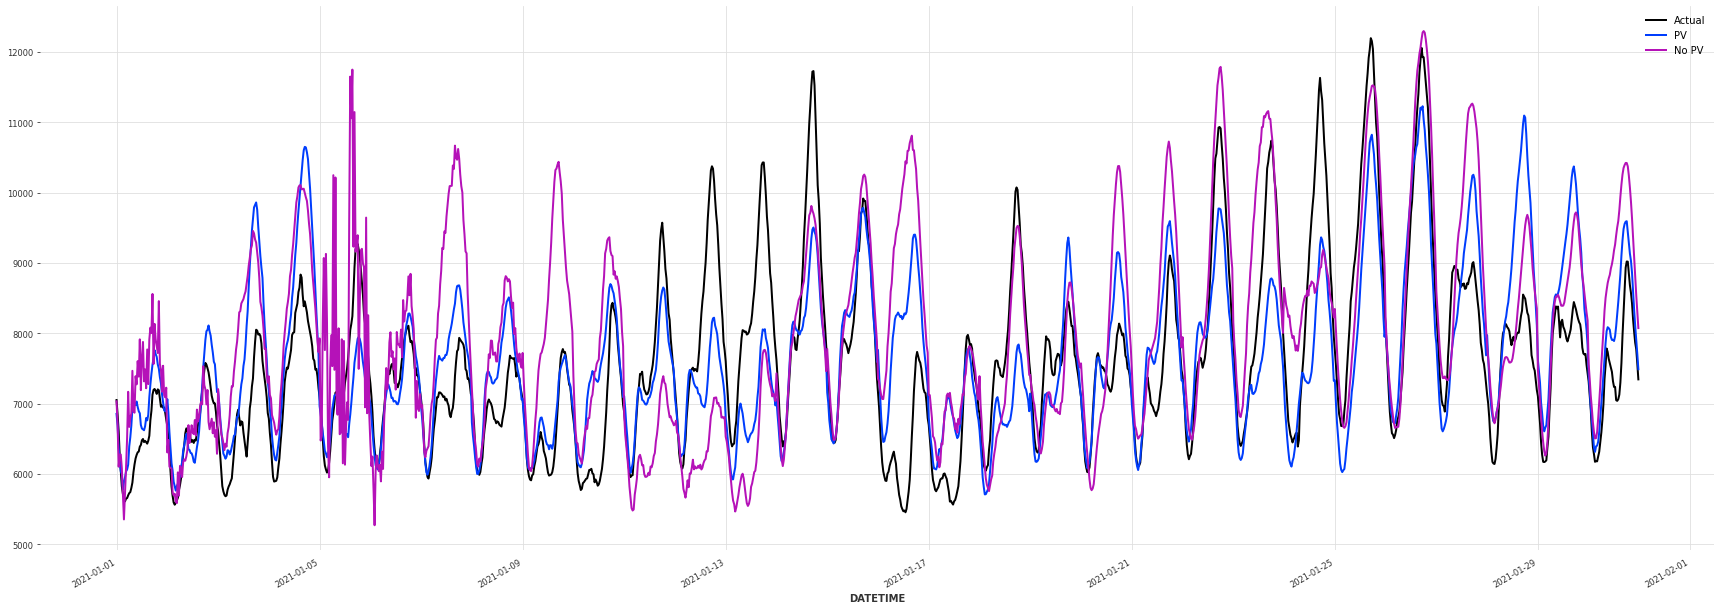

In [7]:
plt.figure(figsize=(30,10))
ref_series['TOTALDEMAND'].plot(label='Actual')
#ref_series['FORECASTDEMAND'].plot(label='AEMO')
pv_series.plot(label='PV')
#naive_forecasts.plot(label='naive')
no_pv_series.plot(label='No PV')

In [8]:
print("AEMO MAPE/RMSE:", mape(ref_series['TOTALDEMAND'], ref_series['FORECASTDEMAND']), rmse(ref_series['TOTALDEMAND'], ref_series['FORECASTDEMAND']))
print("Naive MAPE/RMSE:", mape(ref_series['TOTALDEMAND'], naive_forecasts), rmse(ref_series['TOTALDEMAND'], naive_forecasts))
print("PV prediction MAPE/RMSE", mape(ref_series['TOTALDEMAND'],pv_series), rmse(ref_series['TOTALDEMAND'],pv_series))
print("Non-PV prediction MAPE/RMSE", mape(ref_series['TOTALDEMAND'],no_pv_series), rmse(ref_series['TOTALDEMAND'],no_pv_series))



AEMO MAPE/RMSE: 2.2116532770951616 223.7927368633153
Naive MAPE/RMSE: 6.817613538552592 796.9969665780311
PV prediction MAPE/RMSE 8.739672752360946 927.4128956016208
Non-PV prediction MAPE/RMSE 12.960164389690712 1288.8569704317383


Calculate the residuals between the predictions and the actuals


In [9]:
pv_diffs =  pv_series - ref_series['TOTALDEMAND']
non_pv_diffs = no_pv_series - ref_series['TOTALDEMAND']

## Histogram of the distribution of errors for PV and non-PV roll-forward forecasts

PV residuals histogram

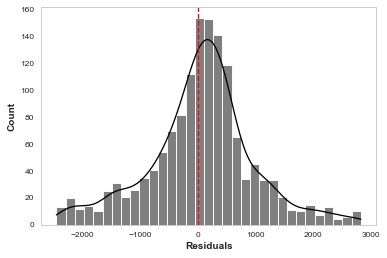

In [20]:
sns.set_style("whitegrid", {'axes.grid' : False})
pv_hist = sns.histplot(data = pv_diffs.pd_dataframe().rename(columns={'TOTALDEMAND':'Residuals'}), x='Residuals', kde=True, color='black')
ax1 = pv_hist.axes
ax1.axvline(0, ls='--', color='red')    



Non-PV residuals histogram

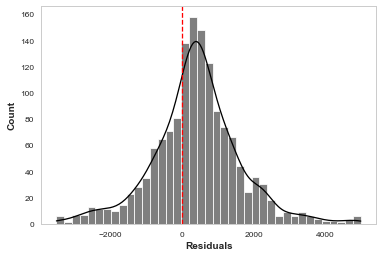

In [21]:
non_pv_hist = sns.histplot(data = non_pv_diffs.pd_dataframe().rename(columns={'TOTALDEMAND':'Residuals'}), x='Residuals', kde=True, color='black')
ax1 = non_pv_hist.axes
ax1.axvline(0, ls='--', color='red')  

Partial auto-correlatioin plot of residuals

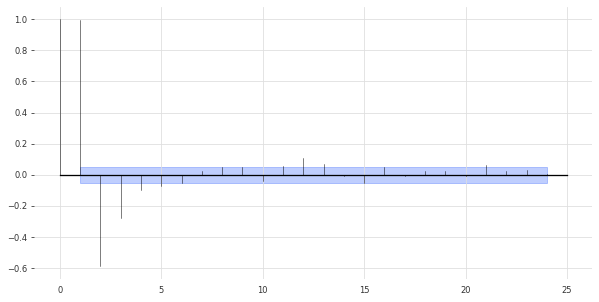

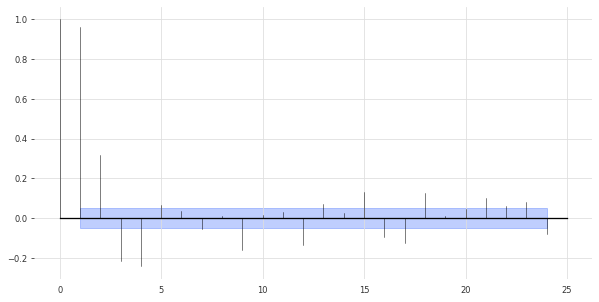

In [20]:
plot_pacf(pv_diffs, alpha=0.05)
plot_pacf(non_pv_diffs, alpha=0.05)

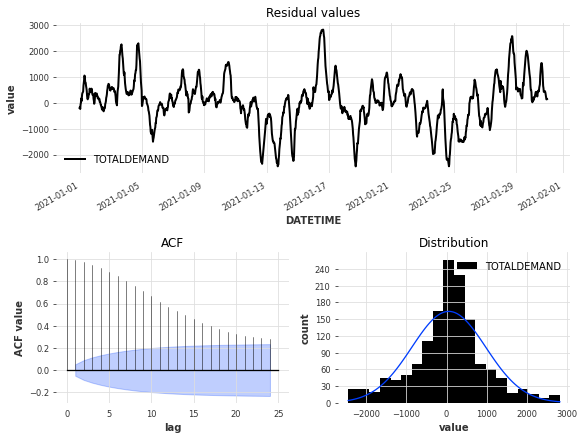

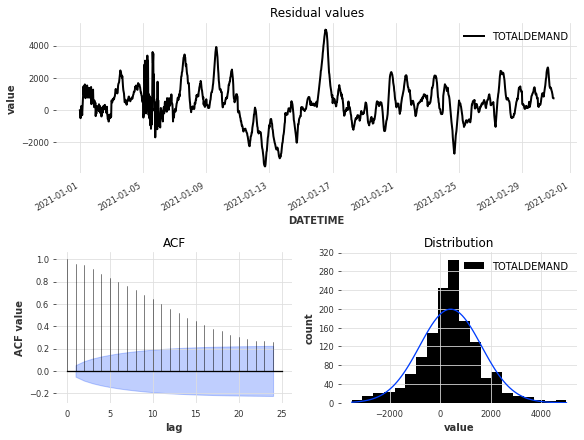

In [21]:
plot_residuals_analysis(pv_diffs)
plot_residuals_analysis(non_pv_diffs)

## Correlation of residuals with other predictors: PV data

In [22]:
def resid_correlation(residuals, main_data):
    cor_df = residuals.pd_dataframe()
    cor_df.rename(columns={'TOTALDEMAND':'RESIDUAL'}, inplace=True)
    return cor_df.merge(main_data, how='left', on='DATETIME')[['RESIDUAL','TOTALDEMAND','POWER','TEMPERATURE']].corr(method='pearson')

In [23]:
resid_correlation(pv_diffs, actual)

,RESIDUAL,TOTALDEMAND,POWER,TEMPERATURE
RESIDUAL,1.000000,-0.529753,-0.030021,-0.379613
TOTALDEMAND,-0.529753,1.000000,0.134145,0.637004
POWER,-0.030021,0.134145,1.000000,0.650362
TEMPERATURE,-0.379613,0.637004,0.650362,1.000000


## Correlation of residuals with other predictors: non-PV data

In [24]:
resid_correlation(non_pv_diffs, actual)

,RESIDUAL,TOTALDEMAND,POWER,TEMPERATURE
RESIDUAL,1.000000,-0.329574,0.090223,-0.127008
TOTALDEMAND,-0.329574,1.000000,0.134145,0.637004
POWER,0.090223,0.134145,1.000000,0.650362
TEMPERATURE,-0.127008,0.637004,0.650362,1.000000


Distribution of errors by time of day

In [28]:
def plot_residuals_by_hour(residuals):
    res = residuals.pd_dataframe()
    res.head()
    res.rename(columns={'TOTALDEMAND':'Residuals'},inplace=True)
    res['Time of day'] = res.index.time

    sns.set(rc={"figure.figsize": (25,5)})
    errorplot = sns.boxplot(data=res, x='Time of day',y='Residuals', color='skyblue')
    errorplot.set_xticklabels(labels=res['Time of day'].unique(), rotation=45)
    ax1 = errorplot.axes
    ax1.axhline(0, ls='--', color='red')    

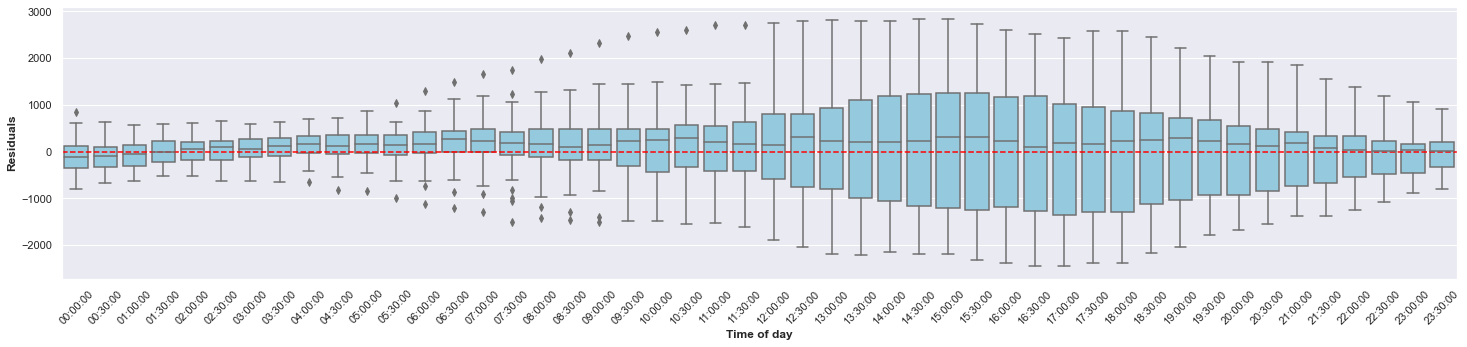

In [40]:


plot_residuals_by_hour(pv_diffs)

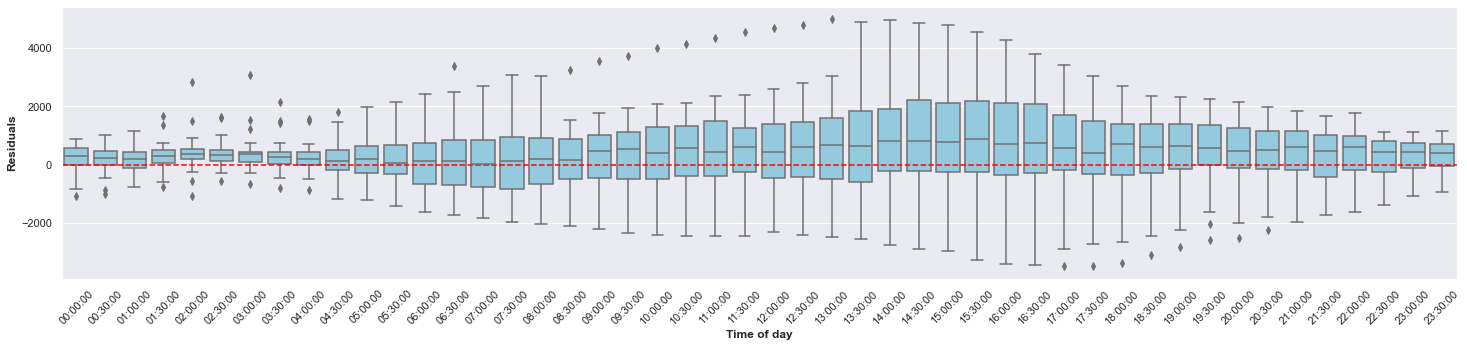

In [41]:
plot_residuals_by_hour(non_pv_diffs)

Calculate the best and worst prediction days (by summing all residuals for that day)

Best 5 days


2021-01-09     7926.556010
2021-01-06     9155.606866
2021-01-15     9803.275057
2021-01-02    13943.413856
2021-01-11    15147.044535
Name: RESIDUAL, dtype: float64

Worst 5 days


2021-01-16    75275.461358
2021-01-13    64133.022522
2021-01-28    56061.351887
2021-01-24    51979.782964
2021-01-25    51167.176691
Name: RESIDUAL, dtype: float64

In [68]:
def daily_sum_relative_residuals(preds, actuals):
    preds_df = preds.pd_dataframe()
    preds_df.rename(columns={'TOTALDEMAND':'PREDICTION'}, inplace=True)
    merge_df = preds_df.merge(actuals, how='left', left_index=True, right_on='DATETIME')
    merge_df['relative_diff'] = abs((merge_df['PREDICTION'] - merge_df['TOTALDEMAND']) / merge_df['TOTALDEMAND'])
    return merge_df.groupby(by=merge_df['DATETIME'].dt.date).aggregate(sum)['relative_diff']

In [71]:
daily_pv_residuals = daily_sum_relative_residuals(pv_series, actual)

print("Best 5 days")
daily_pv_residuals.sort_values().head(5)

print("Worst 5 days")
daily_pv_residuals.sort_values(ascending=False).head(5)

Best 5 days


DATETIME
2021-01-15    1.235186
2021-01-06    1.235936
2021-01-09    1.245944
2021-01-11    1.866612
2021-01-02    2.082413
Name: relative_diff, dtype: float64

Worst 5 days


DATETIME
2021-01-16    12.241722
2021-01-13     7.415074
2021-01-28     7.159609
2021-01-03     6.511147
2021-01-18     5.905072
Name: relative_diff, dtype: float64